In [4]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [5]:
df = pd.read_csv("premierleaguepassing.csv")
columns = ['Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1',
       'Cmp.2', 'Att.2', 'Cmp.3', 'Att.3', 'Ast', 'xAG',
       'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

# Set all columns to per 90 minutes
for col in columns:
    df[col] = df[col]/df["90s"] 
df = df.dropna()
df
df.columns

Index(['Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s',
       'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1',
       'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG',
       'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Matches'],
      dtype='object')

In [6]:
df.sort_values("Att", ascending = False)

,Unnamed: 0,Player,Nation,Pos,Squad,Age,Born,90s,Cmp,Att,...,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP,Matches
345,345,Benjamin Mendy,fr FRA,DF,Manchester City,27.0,1994.0,0.9,88.888889,104.444444,...,0.000000,0.111111,0.111111,-0.111111,2.222222,10.000000,1.111111,1.111111,10.000000,Matches
190,190,Morgan Gibbs-White,eng ENG,"DF,FW",Wolves,21.0,2000.0,0.1,70.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,20.000000,Matches
69,69,João Cancelo,pt POR,DF,Manchester City,27.0,1994.0,35.9,78.245125,93.732591,...,0.194986,0.150418,0.183844,0.044568,1.086351,8.579387,2.674095,0.334262,9.944290,Matches
286,286,Aymeric Laporte,es ESP,DF,Manchester City,27.0,1994.0,31.4,88.598726,93.630573,...,0.000000,0.019108,0.041401,-0.019108,0.286624,9.840764,0.286624,0.063694,8.630573,Matches
563,563,Oleksandr Zinchenko,ua UKR,DF,Manchester City,24.0,1996.0,11.6,82.155172,92.500000,...,0.344828,0.232759,0.215517,0.112069,1.379310,8.965517,1.896552,0.431034,9.741379,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,405,Teemu Pukki,fi FIN,FW,Norwich City,31.0,1990.0,36.1,11.052632,14.958449,...,0.083102,0.105263,0.080332,-0.022161,0.747922,0.581717,0.166205,0.027701,0.941828,Matches
532,532,Matěj Vydra,cz CZE,FW,Burnley,29.0,1992.0,7.5,10.000000,14.266667,...,0.400000,0.093333,0.080000,0.306667,0.800000,0.133333,0.266667,0.000000,0.933333,Matches
528,528,Jamie Vardy,eng ENG,FW,Leicester City,34.0,1987.0,20.1,9.154229,13.184080,...,0.099502,0.069652,0.049751,0.029851,0.895522,0.447761,0.746269,0.099502,1.393035,Matches
94,94,Aaron Connolly,ie IRL,"FW,MF",Brighton,21.0,2000.0,1.7,8.235294,11.176471,...,0.000000,0.058824,0.058824,-0.058824,0.588235,0.000000,0.000000,0.000000,0.588235,Matches


Team (mean passes, max passes (per person)): Norwich City 37 60.33980582524271
Standard Deviation: 11.712438455644126
Team (mean passes, max passes (per person)): Southampton 36 59.85994397759103
Standard Deviation: 12.819639586304998
Team (mean passes, max passes (per person)): Wolves 46 100.0
Standard Deviation: 16.8570396885878
Team (mean passes, max passes (per person)): Brentford 37 61.44230769230769
Standard Deviation: 12.695061658096831
Team (mean passes, max passes (per person)): Manchester City 65 104.44444444444444
Standard Deviation: 24.368505100298893
Team (mean passes, max passes (per person)): Leicester City 48 75.42857142857143
Standard Deviation: 16.651521293244805
Team (mean passes, max passes (per person)): Liverpool 58 88.70588235294117
Standard Deviation: 19.998103195045037
Team (mean passes, max passes (per person)): Everton 34 54.0
Standard Deviation: 8.51062858059478
Team (mean passes, max passes (per person)): Tottenham 49 72.3943661971831
Standard Deviation: 15

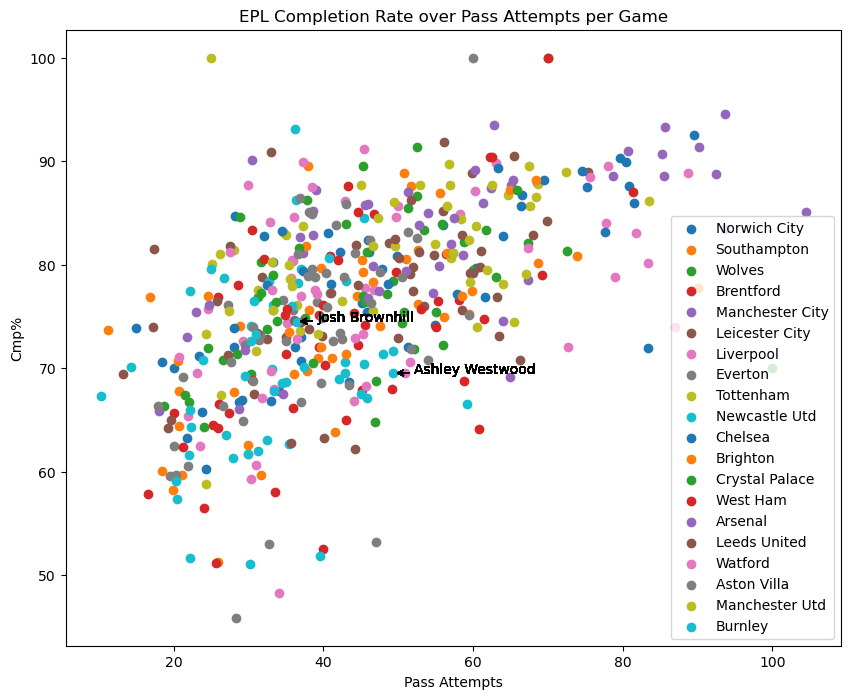

In [8]:
unique_team = df.Squad.unique()

fig, ax = plt.subplots(figsize=(10, 8))

passData = []
teams = []
means = []
maxes = []

for squad in unique_team:

    squad_data = df[df['Squad'] == squad]
    #print("Team:", squad)
    if not pd.isna(squad):
        print("Team (mean passes, max passes (per person)):",squad, int(squad_data.Att.mean()), squad_data.Att.max())

        x = squad_data.Att
        y = squad_data["Cmp%"]
        print("Standard Deviation:",x.std())
        ax.scatter(x, y, marker='o', label=squad)
        passData.append([squad, squad_data.Att.mean(), squad_data.Att.max(), squad_data.Att.std()])
        teams.append(squad)
        means.append(squad_data.Att.mean())
        maxes.append(squad_data.Att.max())
        keyPlayers = ["Ashley Westwood", "Josh Brownhill"]
        annotations = []
        for j, row in df.iterrows():
            if (row["Player"] in keyPlayers):
                ax.annotate(row['Player'], (row.Att, row["Cmp%"]), xytext=(15, 0), textcoords='offset points', arrowprops=dict(arrowstyle='->'))


ax.set_xlabel('Pass Attempts')
ax.set_ylabel('Cmp%')
ax.set_title('EPL Completion Rate over Pass Attempts per Game')


ax.legend()


plt.show()

In [9]:
passData

[['Norwich City', 37.257875135557974, 60.33980582524271, 11.712438455644126],
 ['Southampton', 36.10658238066297, 59.85994397759103, 12.819639586304998],
 ['Wolves', 46.45165208458058, 100.0, 16.8570396885878],
 ['Brentford', 37.886282378434416, 61.44230769230769, 12.695061658096831],
 ['Manchester City',
  65.22076794461672,
  104.44444444444444,
  24.368505100298893],
 ['Leicester City', 48.84758913288515, 75.42857142857143, 16.651521293244805],
 ['Liverpool', 58.78324569610469, 88.70588235294117, 19.998103195045037],
 ['Everton', 34.66189908554893, 54.0, 8.51062858059478],
 ['Tottenham', 49.812187939202396, 72.3943661971831, 15.200766147831201],
 ['Newcastle Utd', 34.63408796866887, 59.16666666666667, 9.544695419910143],
 ['Chelsea', 59.37664302208697, 89.59183673469389, 21.094158909747197],
 ['Brighton', 48.451837815510366, 90.0, 18.41383234564782],
 ['Crystal Palace', 43.324102353380106, 72.56172839506173, 14.611012630888325],
 ['West Ham', 46.75302904263206, 81.35135135135135, 15

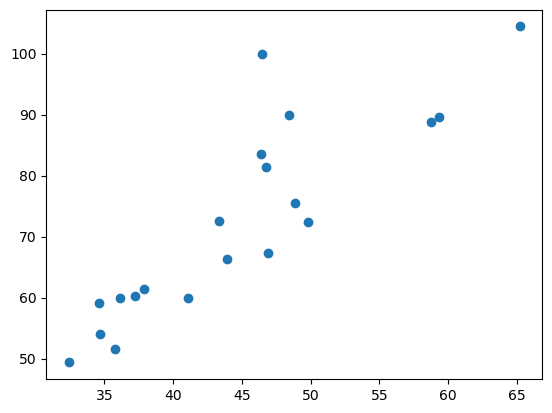

In [10]:
passData.sort()
plt.scatter(means,maxes)

In [11]:
df.loc[df.Squad == "Burnley"].sort_values("Cmp%")

,Unnamed: 0,Player,Nation,Pos,Squad,Age,Born,90s,Cmp,Att,...,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP,Matches
403,403,Nick Pope,eng ENG,GK,Burnley,29.0,1992.0,36.0,15.444444,30.222222,...,0.000000,0.002778,0.005556,-0.002778,0.055556,1.361111,0.083333,0.000000,0.000000,Matches
220,220,Wayne Hennessey,wls WAL,GK,Burnley,34.0,1987.0,2.0,20.500000,39.500000,...,0.000000,0.100000,0.050000,-0.100000,1.500000,3.000000,0.000000,0.000000,0.000000,Matches
554,554,Chris Wood,nz NZL,FW,Burnley,29.0,1991.0,15.2,11.710526,20.394737,...,0.000000,0.032895,0.026316,-0.032895,0.592105,1.776316,0.263158,0.000000,1.513158,Matches
429,429,Jay Rodriguez,eng ENG,FW,Burnley,32.0,1989.0,15.4,12.012987,20.324675,...,0.129870,0.136364,0.032468,-0.006494,0.779221,1.038961,0.194805,0.064935,1.233766,Matches
47,47,Jóhann Berg Guðmundsson,is ISL,MF,Burnley,30.0,1990.0,12.2,17.131148,27.950820,...,0.081967,0.040984,0.065574,0.040984,0.491803,0.573770,0.901639,0.737705,1.311475,Matches
36,36,Ashley Barnes,eng ENG,FW,Burnley,31.0,1989.0,9.0,13.555556,22.000000,...,0.000000,0.100000,0.111111,-0.100000,0.888889,2.333333,0.555556,0.111111,1.888889,Matches
542,542,Wout Weghorst,nl NED,FW,Burnley,28.0,1992.0,16.1,17.142857,26.956522,...,0.186335,0.093168,0.080745,0.093168,0.869565,1.055901,0.434783,0.062112,1.614907,Matches
97,97,Maxwel Cornet,ci CIV,"FW,MF",Burnley,24.0,1996.0,19.6,14.336735,22.295918,...,0.051020,0.086735,0.086735,-0.035714,0.765306,0.765306,0.714286,0.204082,1.530612,Matches
289,289,Aaron Lennon,eng ENG,"MF,FW",Burnley,34.0,1987.0,17.2,14.651163,22.209302,...,0.000000,0.029070,0.029070,-0.029070,0.523256,0.813953,0.232558,0.116279,1.104651,Matches
423,423,Connor Roberts,wls WAL,DF,Burnley,25.0,1995.0,18.8,30.797872,45.904255,...,0.053191,0.063830,0.079787,-0.010638,0.691489,2.446809,0.904255,0.265957,3.244681,Matches


In [7]:
attempts = df.sort_values("Att").Player
attempts
count = 1
keyPlayers = ["Ashley Westwood", "Josh Brownhill"]
for name in attempts:
    #print(a)
    if (name == "Ashley Westwood"):
        print(count)

1


<BarContainer object of 507 artists>

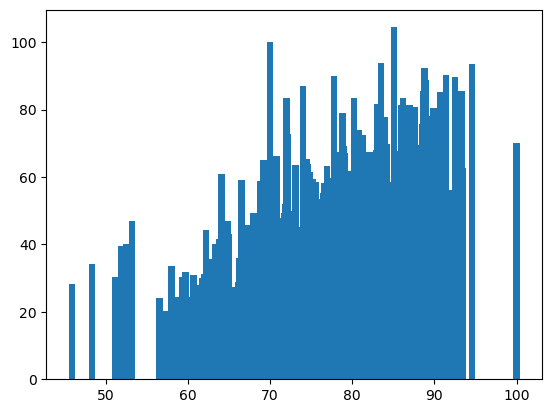

In [8]:
#plt.bar(df.loc[df.Squad == "Burnley"]["Att"],df.loc[df.Squad == "Burnley"]["Cmp%"])
plt.bar(df["Cmp%"], df.Att)

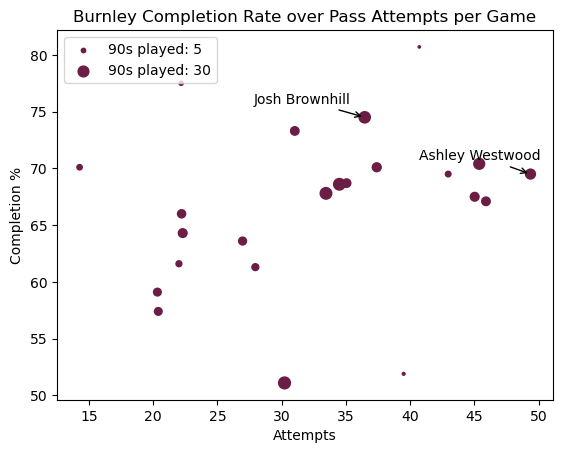

In [35]:

mean = df.loc[df.Squad == "Burnley"]["Att"].mean()
std_dev = df.loc[df.Squad == "Burnley"]["Att"].std()


#x = np.linspace(df.loc[df.Squad == "Burnley"].Att.min(), df.loc[df.Squad == "Burnley"].Att.max())
x_axis = np.arange(df.loc[df.Squad == "Burnley"].Att.min(), df.loc[df.Squad == "Burnley"].Att.max(), 0.1)

mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
  
#plt.plot(x_axis, norm.pdf(x_axis, mean, sd)*50*df.loc[df.Squad == "Burnley"].Att.max())

#plt.plot(x, y, color='red')
x = df.loc[df.Squad == "Burnley"].Att
y = df.loc[df.Squad == "Burnley"]["Cmp%"]
# Plot the points and connect them with lines
plt.scatter(x, y, marker='o', label=squad, s=df.loc[df.Squad == "Burnley"]["90s"]*2, c="#6C1D45")
keyPlayers = ["Ashley Westwood", "Josh Brownhill"]
annotations = []
for j, row in df.loc[df.Squad == "Burnley"].iterrows():
    #print(row)
    if (row["Player"] in keyPlayers):
        plt.annotate(row['Player'], (row.Att, row["Cmp%"]), xytext=(-80, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->'))

legend_elements = [
    plt.scatter([], [], s=10, c="#6C1D45", label='90s played: 5'),
    plt.scatter([], [], s=60, c ="#6C1D45", label='90s played: 30')]
plt.legend(handles=legend_elements)


plt.title('Burnley Completion Rate over Pass Attempts per Game')
plt.xlabel('Attempts')
plt.ylabel('Completion %')


plt.show()

In [10]:
df.columns

Index(['Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s',
       'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1',
       'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG',
       'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Matches'],
      dtype='object')

In [11]:
#K means clustering

kdf = df.copy()
kdf.Age = pd.to_numeric(kdf.Age, errors ='coerce')
kdf = kdf.loc[kdf["90s"] >= 1]

#Drop categories that are unimportant
features = kdf.drop(['Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Matches', '90s'], axis=1).dropna()


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


k = 4  # Number of clusters
kmeans_model = KMeans(n_clusters=k, random_state=0)
kmeans_model.fit(features_scaled)


kdf = kdf.drop(['Unnamed: 0', 'Nation', 'Matches'], axis=1).dropna()

kdf['Cluster'] = kmeans_model.labels_


print(kdf[['Player', 'Cluster']])


C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


                   Player  Cluster
0              Max Aarons        2
1               Che Adams        1
2         Rayan Aït Nouri        2
3         Kristoffer Ajer        1
4              Nathan Aké        3
..                    ...      ...
562  Christoph Zimmermann        2
563   Oleksandr Zinchenko        3
564          Hakim Ziyech        1
565            Kurt Zouma        2
566       Martin Ødegaard        3

[487 rows x 2 columns]


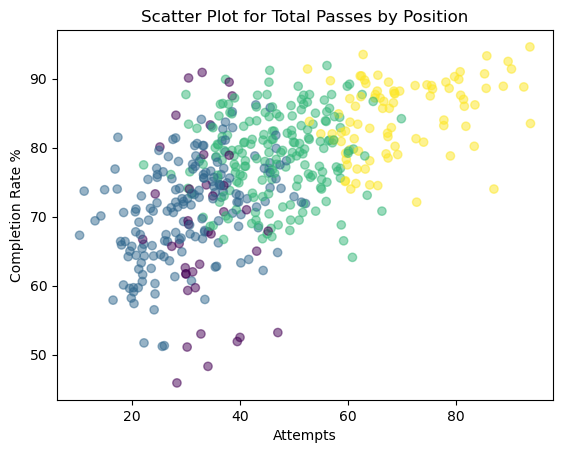

In [30]:


columns_to_compare = ['GA90', 'Saves', 'CS%', "SoTA"] 


    
x = kdf["Att"]
y = kdf["Cmp%"]
cluster_labels = kdf['Cluster']

plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel("Attempts")
plt.ylabel("Completion Rate %")
plt.title('Scatter Plot for Total Passes by Position')



plt.show()

In [13]:
kdf.Pos = kdf.Pos.apply(lambda p: p[0:2])

In [14]:
# How many players were sorted into each cluster
for pos in kdf.Pos.unique():
    print(pos)
    print(kdf.loc[kdf.Pos == pos].groupby("Cluster").Cluster.count())

DF
Cluster
1     15
2    122
3     43
Name: Cluster, dtype: int64
FW
Cluster
1    108
2      1
3      2
Name: Cluster, dtype: int64
MF
Cluster
1    49
2    62
3    44
Name: Cluster, dtype: int64
GK
Cluster
0    39
2     2
Name: Cluster, dtype: int64


In [15]:
kdf.groupby("Cluster").Cluster.count()

Cluster
0     39
1    172
2    187
3     89
Name: Cluster, dtype: int64

In [16]:
kdf.loc[kdf.Pos == "GK"].groupby("Cluster").Cluster.count()

Cluster
0    39
2     2
Name: Cluster, dtype: int64

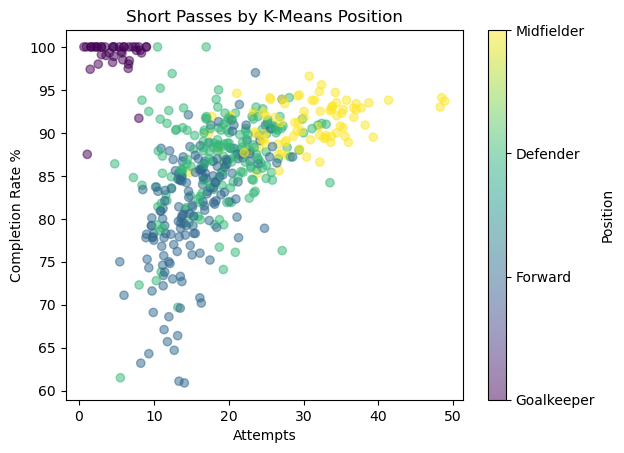

In [28]:

columns_to_compare = ['GA90', 'Saves', 'CS%', "SoTA"]


x = kdf["Att.1"]
y = kdf["Cmp%.1"]
cluster_labels = kdf['Cluster']
positions = ["GK", "DF", "MF", "FW"]


plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel("Attempts")
plt.ylabel("Completion Rate %")
plt.title('Short Passes by K-Means Position')
colorbar = plt.colorbar()

ticks = np.linspace(0, 3, 4)
labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(labels)


colorbar.set_label('Position')

plt.show()

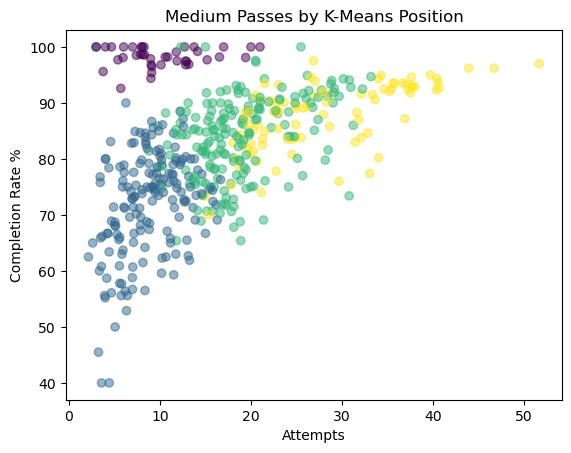

In [29]:

columns_to_compare = ['GA90', 'Saves', 'CS%', "SoTA"]

    
x = kdf["Att.2"]
y = kdf["Cmp%.2"]
cluster_labels = kdf['Cluster']
positions = ["GK", "DF", "MF", "FW"]


plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel("Attempts")
plt.ylabel("Completion Rate %")
plt.title('Medium Passes by K-Means Position')

plt.show()

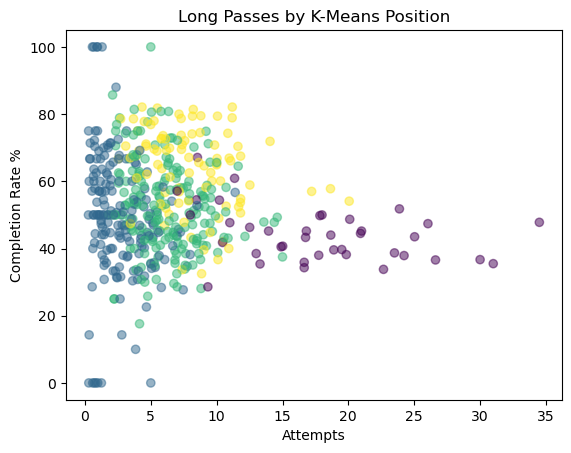

In [31]:
columns_to_compare = ['GA90', 'Saves', 'CS%', "SoTA"] 


    
x = kdf["Att.3"]
y = kdf["Cmp%.3"]
cluster_labels = kdf['Cluster']
positions = ["GK", "DF", "MF", "FW"]


plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel("Attempts")
plt.ylabel("Completion Rate %")
plt.title('Long Passes by K-Means Position')

plt.show()

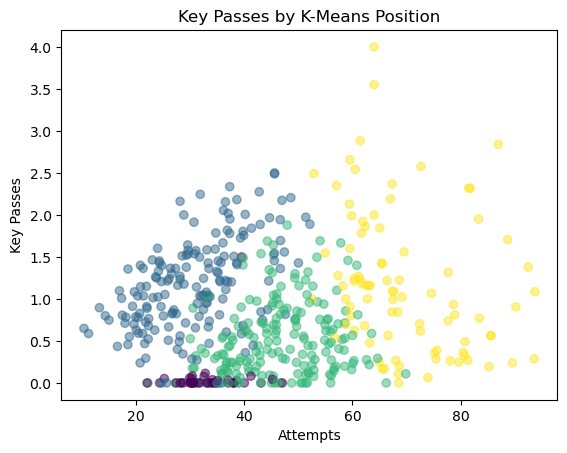

In [32]:
columns_to_compare = ['GA90', 'Saves', 'CS%', "SoTA"] 


x = kdf["Att"]
y = kdf["KP"]
cluster_labels = kdf['Cluster']
positions = ["GK", "DF", "MF", "FW"]

plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel("Attempts")
plt.ylabel("Key Passes")
plt.title("Key Passes by K-Means Position")

plt.show()

In [12]:

columns_to_compare = ['GA90', 'Saves', 'CS%', "SoTA"]

x = kdf["Att"]
y = kdf["1/3"]
cluster_labels = kdf['Cluster']
positions = ["GK", "DF", "MF", "FW"]


plt.scatter(x, y, c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel("Attempts")
plt.ylabel("Passes into Final Third")
plt.title('Passes into the Final Third by K-Means Position')

plt.show()

NameError: name 'kdf' is not defined